# Table of Contents
* 1. Import and review data  
        * 1.1 Import packages  
        * 1.2 Import data  
* 2. K-Nearest Neighbors
* 3. Random Forest
* 4. Gradient Boosting Machines - LightGBM
* 5. Support Vector Regression - RBF

      

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
#confirm the disk location is correct for importing
os.chdir('C:/Users/steve/Documents/springboard/Capstone2/data')
cwd = os.getcwd()
print(cwd)

C:\Users\steve\Documents\springboard\Capstone2\data


In [3]:
%%time
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train_df = pd.read_csv('y_train.csv')
y_test_df = pd.read_csv('y_test.csv')

CPU times: total: 20.9 s
Wall time: 49.9 s


In [9]:
X_train.columns = X_train.columns.str.replace(r"[^\w]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[^\w]", "_", regex=True)
y_train = y_train_df.values.ravel()
y_test = y_test_df.values.ravel()

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5605173, 166)
(5605173,)
(1401294, 166)
(1401294,)


In [11]:
# Split the training and test data into a smaller sample
from sklearn.model_selection import train_test_split

sample_fraction = 0.1

X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=1-sample_fraction, random_state=42)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test, y_test, test_size=1-sample_fraction, random_state=42)


In [7]:
print(X_train_sample.shape)
print(y_train_sample.shape)
print(X_test_sample.shape)
print(y_test_sample.shape)

(280258, 166)
(280258,)
(70064, 166)
(70064,)


# K-Nearest Neighbors

In [ ]:
%%time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from scipy.stats import randint

kf=KFold(n_splits=5, shuffle=True, random_state=42)

param_grid_knn = {
    'n_neighbors': np.arange(1,15),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]}

knn = KNeighborsRegressor()

knn_rs= RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid_knn,
    cv=kf,
    verbose=2,
    n_jobs=-1,
    random_state=42)


In [ ]:
%%time
knn_rs.fit(X_train_sample,y_train_sample)


In [ ]:
print("Best Score:" + str(knn_rs.best_score_))
print("Best Parameters: " + str(knn_rs.best_params_))

In [ ]:
# Making predictions with the best estimator
knn_best = random_search.best_estimator_
y_pred_knn = knn_best.predict(X_test_sample)



In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=13)

In [ ]:
%%time
knn.fit(X_train_sample,y_train_sample)

In [ ]:
%%time
y_pred_knn = knn.predict(X_test_sample)

In [ ]:
%%time

print(f'Train score: {knn.score(X_train_sample,y_train_sample)}')
print(f'Test score: {knn.score(X_test_sample,y_test_sample)}')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_sample, y_pred_knn)
mse = mean_squared_error(y_test_sample, y_pred_knn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_sample, y_pred_knn)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')


In [ ]:
%%time
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
kf=KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {'n_neighbors':np.arange(1,15)}
knn = KNeighborsRegressor()
knn_cv= RandomizedSearchCV(knn,param_grid,cv=kf, verbose=2, n_iter=1, random_state=42)
knn_cv.fit(X_train_sample,y_train_sample)

In [ ]:
%%time
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

In [ ]:
X_train

# Random Forest

In [8]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Define the objective function to optimize
def rf_eval(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    """
    Trains a Random Forest with given hyperparameters and returns -mse.
    """
    # Convert parameters appripirate types 
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    
    # Create Model
    rfbo = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1,)
    
    rfbo.fit(X_train_sample, y_train_sample)
    y_pred_rfbo = rfbo.predict(X_test_sample)
    mse = mean_squared_error(y_test_sample, y_pred_rfbo)
    return -mse  


In [ ]:
# Define the parameter search space
pbounds_rf = {
    "n_estimators": (50, 200),  
    "max_depth": (5, 50), 
    "min_samples_split": (2, 10), 
    "min_samples_leaf": (1, 10),}

In [ ]:
# Set up the optimizer
optimizer_rf = BayesianOptimization(
    f=rf_eval,  
    pbounds=pbounds_rf, 
    random_state=42,
    verbose=2)

In [ ]:
%%time
# Run optimization
optimizer_rf.maximize(init_points=4, n_iter=8)

# Print best parameters
print("Best hyperparameters found:", optimizer.max)

In [ ]:
# Extract the best parameters
best_params_rf = optimizer_rf.max['params']
best_params_rf['num_leaves'] = int(best_params_rf['num_leaves'])
best_params_rf['max_depth'] = int(best_params_rf['max_depth'])
best_params_rf['learning_rate'] = float(best_params_rf['learning_rate'])
best_params_rf['n_estimators'] = int(best_params_rf['n_estimators'])
best_params_rf['subsample'] = float(best_params_rf['subsample'])

In [ ]:
%%time
# Train the final model with the best parameters
rf_best = RandomForestRegressor(**best_params_rf, random_state=42,n_jobs=-1, verbose=2)
rf_best.fit(X_train, y_train)

In [ ]:
#%%time
#rf_best = RandomForestRegressor(n_estimators=150,
                             max_depth=45, 
                             min_samples_split=8, 
                             min_samples_leaf=8,
                             random_state=42,
                             verbose=2,
                             n_jobs=-1)
#rf_best.fit(X_train, y_train)

In [ ]:
%%time
y_pred_rf_best= rf_best.predict(X_test)

In [ ]:
# Calculate evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf_best)
mse_rf = mean_squared_error(y_test, y_pred_rf_best)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf_best)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_rf}')
print(f'Mean Squared Error (MSE): {mse_rf}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'R-squared (R2): {r2_rf}')

# Gradient Boosting Machines - LightGBM

In [12]:
import lightgbm as lgb

In [13]:
# Define the objective function to optimize
def lgb_eval(n_estimators, learning_rate, num_leaves, max_depth, subsample, colsample_bytree ):
    """
    Trains a LightGBM with given hyperparameters and returns the returns -mse
    """
    n_estimators =  int(n_estimators)
    learning_rate = float(learning_rate)
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    subsample = float(subsample)
    colsample_bytree = float(colsample_bytree)
        
    # Create Model
    lgbbo = lgb.LGBMRegressor(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    num_leaves=num_leaves,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=42)
    
    lgbbo.fit(X_train_sample, y_train_sample)
    y_pred_lgbbo = lgbbo.predict(X_test_sample)
    mse = mean_squared_error(y_test_sample, y_pred_lgbbo)
    return -mse  

In [14]:
param_bounds_lgb = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 0.2),    
    'num_leaves': (20, 100),
    'max_depth': (5, 50),  
    'subsample': (0.6, 1.0),
    "colsample_bytree": (0.6, 1.0)}
    

In [15]:
optimizer_lgb = BayesianOptimization(
    f=lgb_eval,
    pbounds=param_bounds_lgb,
    random_state=42,
    verbose=2)

In [16]:
%%time
# Run optimization
optimizer_lgb.maximize(init_points=10, n_iter=50)

# Print best parameters
print("Best hyperparameters found:", optimizer_lgb.max)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 560517, number of used features: 160
[LightGBM] [Info] Start training from score 0.000386
| 1         | -0.864    | 0.7498    | 0.1906    | 37.94     | 339.5     | 32.48     | 0.6624    |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 11        | -0.8626   | 0.844     | 0.06945   | 17.2      | 339.1     | 89.29     | 0.9787    |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 560517, number of used features: 160
[LightGBM] [Info] Start training from score 0.000386
| 12        | -0.8584   | 0.9537    | 0.1766    | 16.23     | 339.6     | 89.59     | 0.806     |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 560517, number of used features: 160
[LightGBM] [Info] Start training from score

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 36        | -0.8638   | 0.9686    | 0.05887   | 19.23     | 342.7     | 93.83     | 0.983     |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 560517, number of used features: 160
[LightGBM] [Info] Start training from score 0.000386
| 37        | -0.8604   | 0.7154    | 0.1468    | 13.34     | 308.4     | 74.44     | 0.8075    |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 560517, number of used features: 160
[LightGBM] [Info] Start training from score

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 53        | -0.8586   | 0.8814    | 0.166     | 21.38     | 307.9     | 80.6      | 0.6135    |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 560517, number of used features: 160
[LightGBM] [Info] Start training from score 0.000386
| 54        | -0.8573   | 0.8892    | 0.1672    | 16.86     | 347.9     | 98.87     | 0.7365    |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 560517, number of used features: 160
[LightGBM] [Info] Start training from score

In [17]:
# Extract the best parameters
best_params_lgb = optimizer_lgb.max['params']
best_params_lgb['n_estimators'] = int(best_params_lgb['n_estimators'])
best_params_lgb['learning_rate'] = float(best_params_lgb['learning_rate'])
best_params_lgb['num_leaves'] = int(best_params_lgb['num_leaves'])
best_params_lgb['max_depth'] = int(best_params_lgb['max_depth'])
best_params_lgb['subsample'] = float(best_params_lgb['subsample'])
best_params_lgb['colsample_bytree'] = float(best_params_lgb['colsample_bytree'])


In [61]:
%%time
# Train the final model with the best parameters
lgb_best = lgb.LGBMRegressor(**best_params_lgb, random_state=42)
lgb_best.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 5605173, number of used features: 166
[LightGBM] [Info] Start training from score 0.000000
CPU times: total: 2min 55s
Wall time: 28.6 s


LGBMRegressor(colsample_bytree=0.6774532586580926,
              learning_rate=0.177733888599508, max_depth=15, n_estimators=350,
              num_leaves=99, random_state=42, subsample=0.935998239256082)

In [62]:
%%time
y_pred_lgb = lgb_best.predict(X_test)

CPU times: total: 25.9 s
Wall time: 4.19 s


In [63]:
# Calculate evaluation metrics
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_lgb}')
print(f'Mean Squared Error (MSE): {mse_lgb}')
print(f'Root Mean Squared Error (RMSE): {rmse_lgb}')
print(f'R-squared (R2): {r2_lgb}')

Mean Absolute Error (MAE): 0.6729225507567893
Mean Squared Error (MSE): 0.8389253343296964
Root Mean Squared Error (RMSE): 0.9159286731671284
R-squared (R2): 0.15943990789265094


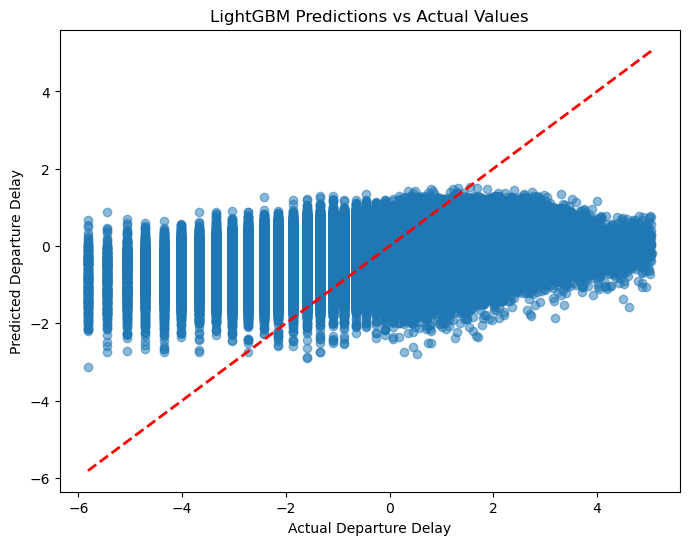

In [35]:
# Scatter plot of True vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=y_pred_lgb, alpha=0.5)

# Plot the perfect prediction line (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel("Actual Departure Delay")
plt.ylabel("Predicted Departure Delay")
plt.title("LightGBM Predictions vs Actual Values")
plt.show()


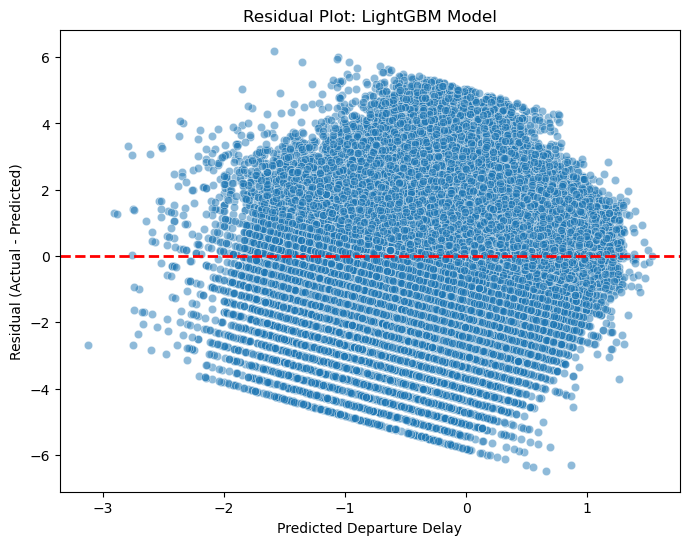

In [34]:
# Compute residuals
residuals = y_test - y_pred_lgb

# Residual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_lgb, y=residuals, alpha=0.5)

# Add a horizontal zero line
plt.axhline(y=0, color='r', linestyle='--', lw=2)

plt.xlabel("Predicted Departure Delay")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot: LightGBM Model")
plt.show()

-5.817409017137459
5.05792596747026


# Support Vector Regression - RBF

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr_model = SVR(kernel='rbf')

In [ ]:
%%time
svr_model.fit(X_train_sample, y_train_sample)




In [ ]:
%%time
y_pred_svr = svr_model.predict(X_test_sample)



In [ ]:
# Evaluating the model
# Calculate evaluation metrics
mae_svr = mean_absolute_error(y_test_sample, y_pred_svr)
mse_svr = mean_squared_error(y_test_sample, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test_sample, y_pred_svr)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_svr}')
print(f'Mean Squared Error (MSE): {mse_svr}')
print(f'Root Mean Squared Error (RMSE): {rmse_svr}')
print(f'R-squared (R2): {r2_svr}')

# XGBoost

In [38]:
import xgboost as xgb


In [50]:
# Define the objective function to optimize
def xgb_eval(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, gamma, min_child_weight, reg_alpha, reg_lambda):
    """
    Trains XGBoot with given hyperparameters and returns -mse.
    """
    n_estimators =  int(n_estimators)
    learning_rate = float(learning_rate)
    max_depth = int(max_depth)
    subsample = float(subsample)
    colsample_bytree = float(colsample_bytree)
    gamma = int(gamma)
    min_child_weight = int(min_child_weight)
    reg_alpha = int(reg_alpha)
    reg_lambda = int(reg_lambda)
    
    
    # Create Model
    xgbbo = xgb.XGBRegressor(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    gamma = gamma,
    min_child_weight = min_child_weight, 
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,    
    random_state=42)
    
    xgbbo.fit(X_train_sample, y_train_sample)
    y_pred_xgbbo = xgbbo.predict(X_test_sample)
    mse = mean_squared_error(y_test_sample, y_pred_xgbbo)
    return -mse  

In [51]:
param_bounds_xgb = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 0.3),    
    'max_depth': (3, 10),  
    'subsample': (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "gamma": (0, 10),
    "min_child_weight": (0, 10),
    "reg_alpha":(0, 10),
    "reg_lambda":(0, 10)}

In [52]:
optimizer_xgb = BayesianOptimization(
    f=xgb_eval,
    pbounds=param_bounds_xgb,
    random_state=42,
    verbose=2)

In [53]:
%%time
# Run optimization
optimizer_xgb.maximize(init_points=10, n_iter=50)

# Print best parameters
print("Best hyperparameters found:", optimizer_xgb.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.879    | 0.6873    | 9.507     | 0.2223    | 7.191     | 1.56      | 162.4     | 0.5808    | 8.662     | 0.8006    |
| 2         | -0.8629   | 0.854     | 0.2058    | 0.2913    | 8.827     | 2.123     | 172.7     | 1.834     | 3.042     | 0.7624    |
| 3         | -0.8866   | 0.716     | 2.912     | 0.1874    | 3.976     | 2.921     | 246.5     | 4.561     | 7.852     | 0.5998    |
| 4         | -0.907    | 0.7571    | 5.924     | 0.02347   | 7.253     | 1.705     | 126.0     | 9.489     | 9.656     | 0.9042    |
| 5         | -0.8648   | 0.6523    | 0.9767    | 0.2084    | 6.081     | 1.22      | 298.1     | 0.3439    | 9.093     | 0.6294    |
| 6         | -0.872    | 0.8313    | 3.117     | 0.1608    | 

| 34        | -0.8569   | 0.9216    | 0.2681    | 0.1842    | 9.849     | 9.894     | 290.2     | 5.921     | 6.807     | 0.6324    |
| 35        | -0.8769   | 0.8677    | 9.424     | 0.2822    | 8.769     | 8.515     | 268.3     | 1.15      | 9.028     | 0.936     |
| 36        | -0.8764   | 0.6651    | 5.788     | 0.2397    | 4.127     | 1.734     | 473.8     | 3.879     | 8.406     | 0.5972    |
| 37        | -0.8604   | 0.7404    | 1.318     | 0.2998    | 6.647     | 9.871     | 290.6     | 5.364     | 9.857     | 0.7142    |
| 38        | -0.8627   | 0.6607    | 0.06683   | 0.2655    | 5.074     | 6.013     | 500.0     | 7.937     | 1.436     | 0.5186    |
| 39        | -0.8685   | 0.759     | 4.299     | 0.2665    | 9.309     | 7.849     | 498.0     | 1.212     | 0.2624    | 0.9123    |
| 40        | -0.8633   | 0.6744    | 2.273     | 0.257     | 5.6       | 9.908     | 499.9     | 7.585     | 9.353     | 0.6282    |
| 41        | -0.8796   | 0.7013    | 9.398     | 0.1759    | 

In [64]:
# Extract the best parameters
best_params_xgb = optimizer_xgb.max['params']
best_params_xgb['n_estimators'] = int(best_params_xgb['n_estimators'])
best_params_xgb['learning_rate'] = float(best_params_xgb['learning_rate'])
best_params_xgb['max_depth'] = int(best_params_xgb['max_depth'])
best_params_xgb['subsample'] = float(best_params_xgb['subsample'])
best_params_xgb['colsample_bytree'] = float(best_params_xgb['colsample_bytree'])
best_params_xgb['gamma'] = int(best_params_xgb['gamma'])
best_params_xgb['min_child_weight'] = int(best_params_xgb['min_child_weight'])
best_params_xgb['reg_alpha'] = int(best_params_xgb['reg_alpha'])
best_params_xgb['reg_lambda'] = int(best_params_xgb['reg_lambda'])


In [65]:
%%time
# Train the final model with the best parameters
xgb_best = xgb.XGBRegressor(**best_params_xgb, random_state=42)
xgb_best.fit(X_train, y_train)


CPU times: total: 23min 10s
Wall time: 2min 29s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9363362088343808, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.26816801437072196, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=454, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [66]:
%%time
# Make predictions
y_pred_xgb = xgb_best.predict(X_test)


CPU times: total: 23.9 s
Wall time: 2.5 s


In [67]:
# Evaluating the model
# Calculate evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae_xgb}')
print(f'Mean Squared Error (MSE): {mse_xgb}')
print(f'Root Mean Squared Error (RMSE): {rmse_xgb}')
print(f'R-squared (R2): {r2_xgb}')

Mean Absolute Error (MAE): 0.6742010919954805
Mean Squared Error (MSE): 0.8419482904238129
Root Mean Squared Error (RMSE): 0.917577402960542
R-squared (R2): 0.15641106116585923
